In [1]:
## How do we get tokens for images??
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [22]:

# Loading data
transform = ToTensor()

train_set = MNIST(root='./datasets', train=True, download=True, transform=transform)
test_set = MNIST(root='./datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
test_loader = DataLoader(test_set, shuffle=False, batch_size=64)

In [3]:
# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

Using device:  cuda (NVIDIA GeForce RTX 3070 Laptop GPU)


# Reshaping the inputs
In this case the image needs to be cut into patches. 
The images from MNIST are 1x28x28 (channel first).
It is a bit delicate to create the patching, and in practice these "patches" become flat vectors.
Also, we only have grayscale images without additional colour channel. 
Those additional colour channels will be delt with later.


In [25]:
import cv2
batch = list(tqdm(train_loader, desc=f"Epoch in training", leave=False))[0]
# print(batch)
x, y = batch
images = x
n_patches = 7
batch_size, channels, height, width = images.shape

assert height == width, "Patchify method is implemented for square images only"

patches = torch.zeros(batch_size, n_patches ** 2, height * width * channels // n_patches ** 2)
## Getting the square patches (batch, n_patches, channels, height / n_patches, width / n_patches)
patches_square = torch.zeros(batch_size, n_patches ** 2, channels, height // n_patches, width // n_patches)
patch_size = height // n_patches

for idx, image in enumerate(images):
    # image = np.array([cv2.resize(np.array(image[0]), (64, 64))])
    for i in range(n_patches):
        for j in range(n_patches):
            patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
            patches_square[idx, i * n_patches + j] = patch
            patches[idx, i * n_patches + j] = patch.flatten()


print("patches", patches.shape)
print("patches_square", patches_square.shape)

patches torch.Size([64, 49, 16])
patches_square torch.Size([64, 49, 1, 4, 4])


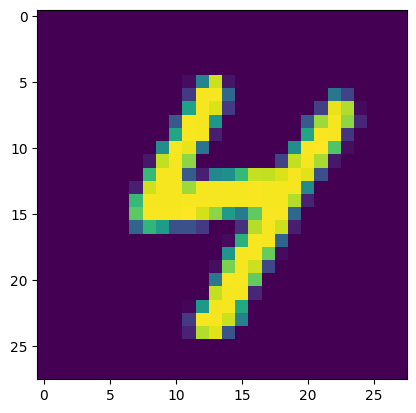

In [27]:
import matplotlib.pyplot as plt

# build image strip to show above actions
image = images[0] ## Now 1x28x28
plt.imshow(image[0]) ## Remove the channel first to plot.


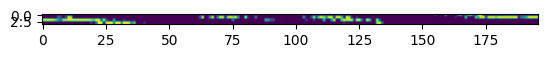

In [28]:
## Stack patches in a row we want 49x4x4 for the patches
image_strip = np.reshape(patches_square[0], (4,4*49)) ## Stack patches in a row we want 49x4x4 for the patches
plt.imshow(image_strip)

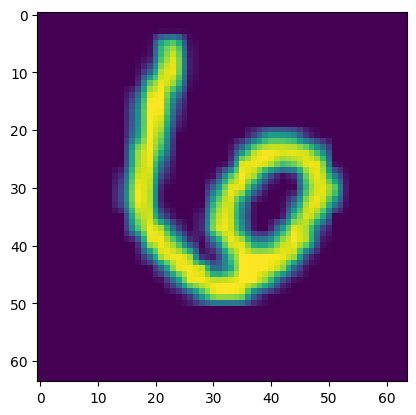

In [15]:
import cv2
image = cv2.resize(np.array(image[0]), (64, 64))
plt.imshow(image)